In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import math

from torchvision.datasets import CIFAR10
from torchvision import transforms
from google.colab.patches import cv2_imshow

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    torch.device("cpu")
print(" > Device: ", device)

 > Device:  cuda:0


# **Coefficient for DDPM**

In [ ]:
T = 1000
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = (1. - betas).to(device)
alphas_bar = torch.cumprod(alphas, dim=0).to(device)
alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.).to(device)

# for training
sqrt_alphas_bar = torch.sqrt(alphas_bar).to(device)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar).to(device)

# for sampling 
reciprocal_alphas_sqrt = torch.sqrt(1. / alphas_bar).to(device)
reciprocal_alphasm1_sqrt = torch.sqrt(1. / alphas_bar - 1.).to(device)
posterior_mean_coef1 = torch.sqrt(alphas_bar_prev) * betas / (1. - alphas_bar).to(device)
posterior_mean_coef2 = torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar).to(device)
sigmas = (betas * (1. - alphas_bar_prev) / (1. - alphas_bar)).to(device)

# for sampling2
reciprocal_alphas_sqrt_ = torch.sqrt(1. / alphas).to(device)
eps_coeff = (betas / torch.sqrt(1. - alphas_bar)).to(device)

# **Training/Sampling algorithm**

In [ ]:
def gather_and_expand(coeff, t, xshape):
    B, *dims = xshape # Batch size, and remainder
    coeff_t = torch.gather(coeff, index=t, dim=0)
    return coeff_t.view([B] + [1]*len(dims))

def train(model, x_0):
    t = torch.randint(T, size=(x_0.shape[0], ), device=x_0.device)
    eps = torch.randn_like(x_0)
    
    x_t = gather_and_expand(sqrt_alphas_bar, t, x_0.shape) * x_0 + \
          gather_and_expand(sqrt_one_minus_alphas_bar, t, x_0.shape) * eps
    
    loss = F.mse_loss(model(x_t, t), eps)
    return loss

def sample(model, x_T):
    x_t = x_T
    for time_step in reversed(range(T)):
        t = torch.full((x_T.shape[0], ), time_step, dtype=torch.long, device=device)
        eps = model(x_t, t)
        x0_predicted = gather_and_expand(reciprocal_alphas_sqrt, t, eps.shape) * x_t - \
            gather_and_expand(reciprocal_alphasm1_sqrt, t, eps.shape) * eps

        mean = gather_and_expand(posterior_mean_coef1, t, eps.shape) * x0_predicted + \
            gather_and_expand(posterior_mean_coef2, t, eps.shape) * x_t
        
        z = torch.randn_like(x_t) if time_step else 0
        var = torch.sqrt(gather_and_expand(sigmas, t, eps.shape)) * z

        x_t = mean + var
    x_0 = x_t
    return x_0

def sample2(model, x_T):
    x_t = x_T
    for time_step in reversed(range(T)):
        t = torch.full((x_T.shape[0], ), time_step, dtype=torch.long, device=device)
        eps = model(x_t, t)

        mean = gather_and_expand(reciprocal_alphas_sqrt_, t, eps.shape) * \
            (x_t - gather_and_expand(eps_coeff, t, eps.shape) * eps)
        
        z = torch.randn_like(x_t) if time_step else 0
        var = torch.sqrt(gather_and_expand(sigmas, t, eps.shape)) * z

        x_t = mean + var
    x_0 = x_t
    return x_0

# **Prepare Dataset/Dataloader**

In [ ]:
dataset = CIFAR10(
    root="./data", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=4
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


# **Model architecture**

https://github.com/w86763777/pytorch-ddpm/blob/master/model.py

위 github에서 copy함(\_\_name\_\_ == "\_\_name\_\_" 제외)

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x

class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h

class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

## **Make model,optimizer, scheduler instance**

In [ ]:
model = UNet(T=T, ch=128, ch_mult=[1, 2, 2, 1], attn=[1],
             num_res_blocks=2, dropout=0.1).to(device)
#ema_model = copy.deepcopy(model)
optim = torch.optim.Adam(model.parameters(), lr=2e-4)
#sched = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=warmup_lr)

# **Train Iteration**

[Epoch: 1 , Iter: 1563/1563]  Loss: 0.042
> Eval at epoch 1


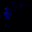

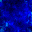

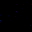

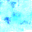

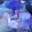

[Epoch: 2 , Iter: 1563/1563]  Loss: 0.018
> Eval at epoch 2


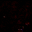

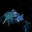

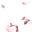

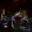

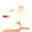

[Epoch: 3 , Iter: 1563/1563]  Loss: 0.013
> Eval at epoch 3


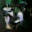

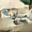

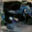

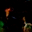

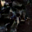

[Epoch: 4 , Iter: 1563/1563]  Loss: 0.049
> Eval at epoch 4


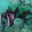

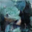

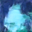

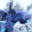

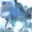

[Epoch: 5 , Iter: 1563/1563]  Loss: 0.015
> Eval at epoch 5


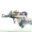

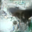

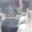

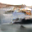

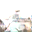

[Epoch: 6 , Iter: 1563/1563]  Loss: 0.019
> Eval at epoch 6


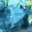

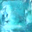

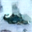

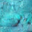

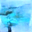

[Epoch: 7 , Iter: 1563/1563]  Loss: 0.023
> Eval at epoch 7


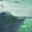

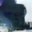

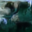

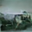

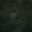

[Epoch: 8 , Iter: 1563/1563]  Loss: 0.012
> Eval at epoch 8


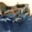

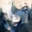

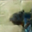

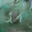

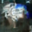

[Epoch: 9 , Iter: 1563/1563]  Loss: 0.018
> Eval at epoch 9


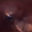

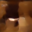

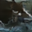

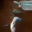

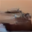

[Epoch: 10 , Iter: 1563/1563]  Loss: 0.012
> Eval at epoch 10


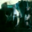

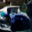

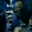

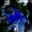

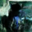

[Epoch: 11 , Iter: 1563/1563]  Loss: 0.013
> Eval at epoch 11


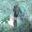

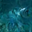

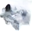

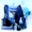

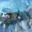

[Epoch: 12 , Iter: 1563/1563]  Loss: 0.021
> Eval at epoch 12


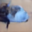

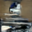

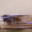

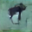

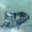

[Epoch: 13 , Iter: 1563/1563]  Loss: 0.020
> Eval at epoch 13


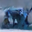

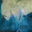

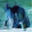

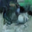

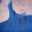

[Epoch: 14 , Iter: 1563/1563]  Loss: 0.032
> Eval at epoch 14


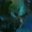

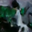

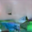

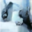

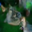

[Epoch: 15 , Iter: 1563/1563]  Loss: 0.018
> Eval at epoch 15


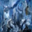

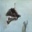

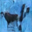

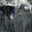

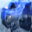

[Epoch: 16 , Iter: 1563/1563]  Loss: 0.019
> Eval at epoch 16


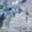

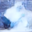

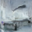

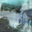

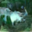

[Epoch: 17 , Iter: 1563/1563]  Loss: 0.005
> Eval at epoch 17


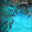

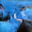

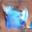

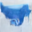

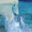

[Epoch: 18 , Iter: 1563/1563]  Loss: 0.014
> Eval at epoch 18


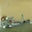

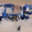

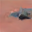

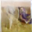

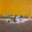

[Epoch: 19 , Iter: 1563/1563]  Loss: 0.042
> Eval at epoch 19


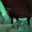

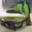

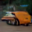

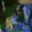

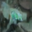

[Epoch: 20 , Iter: 1563/1563]  Loss: 0.008
> Eval at epoch 20


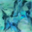

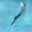

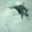

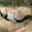

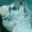

[Epoch: 21 , Iter: 1563/1563]  Loss: 0.024
> Eval at epoch 21


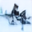

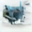

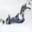

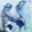

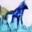

[Epoch: 22 , Iter: 1563/1563]  Loss: 0.042
> Eval at epoch 22


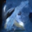

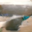

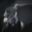

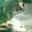

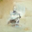

[Epoch: 23 , Iter: 278/1563]  Loss: 0.024

KeyboardInterrupt: ignored

In [ ]:
for e in range(1, 100+1):
    model.train()
    for i, (x, _) in enumerate(dataloader, 1):
        optim.zero_grad()
        x = x.to(device)
        loss = train(model, x)
        loss.backward()
        optim.step()
        print("\r[Epoch: {} , Iter: {}/{}]  Loss: {:.3f}".format(e, i, len(dataloader), loss.item()), end='')
    print("\n> Eval at epoch {}".format(e))
    model.eval()
    with torch.no_grad():
        x_T = torch.randn(5, 3, 32, 32).to(device)
        x_0 = sample(model, x_T)
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        for i in range(5):
            cv2_imshow(x_0[i])
 